## INSY670 - Group Project: Multimodal network and textual analysis of Reddit engagement during exam seasons at McGill and Concordia (2021–2022)

***This notebook focuses on Mcgill only***

Date: April 22nd, 2025

By: Karen Bou Daou (260957944) ; Richard El Chaar (261221829) ; Margot Gerard (260912691) ; Juliana Hubacova (261199618) ; Zaid Mahmood (261228483)

### **Project Overview**

This project investigates Reddit activity in the r/mcgill subreddit during exam seasons (April & December 2021–2022) using a multimodal analysis framework combining network analysis, natural language processing (NLP), and graph-based predictive modeling. The goal was to uncover key themes, detect influential users, and predict engagement in academic discussions.

The workflow includes:

- Data Preparation: Cleaned and filtered Reddit posts and comments, isolating content from McGill during peak exam periods. Key fields (author, timestamps, text, scores) were retained for analysis.
- Network Construction: Built a directed interaction graph (5,323 users, 21,095 edges) representing reply relationships between users.
- Centrality & Visualization: Identified influential users using degree, closeness, betweenness, eigenvector, and Katz centralities. Visualized the top 30 most connected users.
- Community Detection: Applied the Louvain algorithm on the largest weakly connected component, identifying 18 communities.
- Topic Modeling: Performed LDA with TF-IDF to uncover dominant themes within communities (e.g., exams, computer science, financial aid, emotional well-being).
- Sentiment Analysis: Used VADER to classify posts as positive, neutral, or negative, revealing a generally optimistic tone across communities.
- Engagement Analysis: Compared average post scores and volumes to highlight which communities are more impactful versus more active.
- Graph Neural Network (GNN): Trained three graphmodel (GCN, GAT, GraphSAGE) classifiers to predict whether a user is likely to have high engagement based on network centrality, sentiment, and topic profile. The best model (GraphSAGE) achieved a test accuracy of 71.58%.

Overall, the project provides a comprehensive lens into how McGill students communicate, seek help, and form digital communities during stressful academic periods.

### **Data Preparation**

We begin by importing and filtering Reddit data from the r/mcgill and r/concordia subreddits, sourced from the RedArcs archive. The dataset includes both posts and comments, and our analysis is restricted to exam periods - April and December of 2021 and 2022 - when student activity is at its peak.

Each university community is represented by two datasets:
- Submissions: Original posts, including fields such as title, selftext, author, timestamp, subreddit, and score.
- Comments: User replies, with fields like body, author, parent_id, timestamp, subreddit, and score.

These datasets allow us to examine both the content and interaction structure of academic discussions across campuses.

Key preprocessing steps:
- Filtering by subreddit and exam months (April, December)
- Selecting relevant columns (e.g., author, post ID, time, text, score)
- Cleaning and normalizing text fields
- Building reply-based user interaction pairs for network construction



In [1]:
import pandas as pd

# Load McGill Datasets
mcgill_comments = pd.read_csv("mcgill_comments.csv")
mcgill_submissions = pd.read_csv("mcgill_submissions.csv")

print('Data succesfully imported.')

C:\Users\ZAID\AppData\Local\Temp\ipykernel_35024\3581908093.py:4: DtypeWarning: Columns (2,23,24,31,39,42,43,49,50,51,52,53,54,56,57,58,62,64,65,69,72,77) have mixed types. Specify dtype option on import or set low_memory=False.
  mcgill_comments = pd.read_csv("mcgill_comments.csv")


Data succesfully imported.


C:\Users\ZAID\AppData\Local\Temp\ipykernel_35024\3581908093.py:5: DtypeWarning: Columns (2,4,6,7,23,24,25,26,27,35,38,48,49,50,56,60,66,69,70,75,76,86,87,89,90,97,100,101,102,104,106,109,114,116,117,118,123,124,127) have mixed types. Specify dtype option on import or set low_memory=False.
  mcgill_submissions = pd.read_csv("mcgill_submissions.csv")


*Keeping relevant columns only* : Out of the original dataset, we retained only the columns most relevant to our project goals, which focus on user interaction, content, and engagement analysis. Specifically:

- From the comments dataset: 'author', 'body', 'name', 'parent_id', 'created_utc', 'subreddit', 'score'
- From the submissions dataset: 'author', 'title', 'selftext', 'id', 'created_utc', 'subreddit', 'score'

These columns allow us to analyze who is interacting, what they are saying, when and where they post, and how the community responds.

In [2]:
# For comments
comment_cols = ['author', 'body', 'name', 'parent_id', 'created_utc', 'subreddit', 'score']
mcgill_comments = mcgill_comments[comment_cols]

# For submissions
submission_cols = ['author', 'title', 'selftext', 'id', 'created_utc', 'subreddit', 'score']
mcgill_submissions = mcgill_submissions[submission_cols]

print('Filtered columns.')

Filtered columns.


*Filtering for exam seasons only* : 
- December = Final exams for the fall semester
- April = Final exams for the winter semester

In [3]:
# Filter function for exam months and valid years
def filter_exam_period(df, timestamp_col='created_utc'):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit='s')
    df = df[df[timestamp_col].dt.month.isin([4, 12])]
    df = df[df[timestamp_col].dt.year.isin([2021, 2022])]
    return df

# Apply to all datasets
mcgill_comments = filter_exam_period(mcgill_comments)
mcgill_submissions = filter_exam_period(mcgill_submissions)

print("Filtered datasets to exam periods.")

Filtered datasets to exam periods.


### **Network Construction**

#### *Cleaning Data* 
To ensure data quality, we filtered out comments and submissions where the author is missing or labeled as *deleted* or *removed*. For comments specifically, we also excluded empty body fields. This step helps us focus the analysis on meaningful, user-generated content and avoid noise from deleted or system-generated posts.

In [4]:
# Clean McGill data
def clean_data(df):
    df = df[df['author'].notna()]
    df = df[~df['author'].isin(['[deleted]', '[removed]'])]
    return df[df['body'].notna() & (df['body'].str.strip() != '')]

mcgill_comments = clean_data(mcgill_comments)
mcgill_submissions = mcgill_submissions[mcgill_submissions['author'].notna()]
mcgill_submissions = mcgill_submissions[~mcgill_submissions['author'].isin(['[deleted]', '[removed]'])]


#### *Build User Interaction Networks* 
To construct the user interaction network, we first create mappings from post and comment IDs to their respective authors. These mappings allow us to trace who replied to whom. Specifically, we:

- Map each submission (id) to its author, using Reddit's t3_ prefix format for submissions.
- Map each comment (name) to its author.

These dictionaries will later be used to identify directed edges in the interaction graph: from the replying user (comment author) to the user being replied to (post or comment author).



In [5]:
# Create a mapping of post and comment IDs → authors
# Map submission ID to author
submission_author_map = {
    f"t3_{row['id']}": row['author'] 
    for _, row in mcgill_submissions.iterrows()
}

# Map comment ID to author
comment_author_map = {
    row['name']: row['author']
    for _, row in mcgill_comments.iterrows()
}

# Create edges from comments
import networkx as nx

edges = []

for _, row in mcgill_comments.iterrows():
    source = row['author']
    parent_id = row['parent_id']
    
    # Comment to Submission
    if parent_id.startswith('t3_') and parent_id in submission_author_map:
        target = submission_author_map[parent_id]
        if target != source:  # avoid self-loops
            edges.append((source, target))
    
    # Comment to Comment
    elif parent_id.startswith('t1_') and parent_id in comment_author_map:
        target = comment_author_map[parent_id]
        if target != source:  # avoid self-loops
            edges.append((source, target))


# Build the Directed Graph
G_mcgill = nx.DiGraph()
G_mcgill.add_edges_from(edges)
print(f"Number of nodes: {G_mcgill.number_of_nodes()}")
print(f"Number of edges: {G_mcgill.number_of_edges()}")

Number of nodes: 5323
Number of edges: 21095


We built a directed interaction graph for the McGill subreddit, where nodes represent users and edges represent replies (from one user to another). The graph consists of 5,323 users and 21,095 interactions. To analyze user engagement, we computed degree distributions:

- Out-degree identifies users who reply often - i.e., active participants in conversations.
- In-degree highlights users who receive many replies - often indicating influential or popular users.

These distributions help surface the most active and most engaged-with users in the community.

Additionally, we checked for isolated nodes - users with no interactions - but found none, indicating that every user in the network is either responding to or being responded to by others, contributing to a fully connected interaction graph.

In [6]:
# Degree Distributions
# Top 10 users by out-degree (users who reply a lot)
out_degrees = sorted(G_mcgill.out_degree(), key=lambda x: x[1], reverse=True)
print("Top 10 users by out-degree (most replies):", out_degrees[:10])

# Top 10 users by in-degree (users who receive many replies)
in_degrees = sorted(G_mcgill.in_degree(), key=lambda x: x[1], reverse=True)
print("Top 10 users by in-degree (most replied to):", in_degrees[:10])

# Check for Isolated Nodes (users who replied to no one and got no replies)
isolated = list(nx.isolates(G_mcgill))
print(f"Number of isolated nodes: {len(isolated)}")

Top 10 users by out-degree (most replies): [('Thermidorien', 391), ('snowflake25911', 306), ('TheJavaSponge', 198), ('AutoModerator', 183), ('BiggerD', 132), ('zvug', 123), ('nonbeeny', 110), ('a1phabets0up', 105), ('I_Know_Mcgill2', 94), ('KeyRepair4', 92)]
Top 10 users by in-degree (most replied to): [('AutoModerator', 410), ('Thermidorien', 286), ('snowflake25911', 238), ('Razwog', 144), ('uglywriter', 135), ('No_Layer_1015', 133), ('TheJavaSponge', 125), ('6aikoyk4', 102), ('The-Anti-Karen', 88), ('nonbeeny', 84)]
Number of isolated nodes: 0


#### *Visualize* 
To visualize the structure of the McGill Reddit interaction network, we focus on the most active users. We selected the top 30 users based on total degree (sum of in- and out-degrees) and created a subgraph containing only those users. This provides a clearer view of key interactions without the clutter of the full graph. The resulting subgraph reveals who is central in the community and how these top users interact with one another.

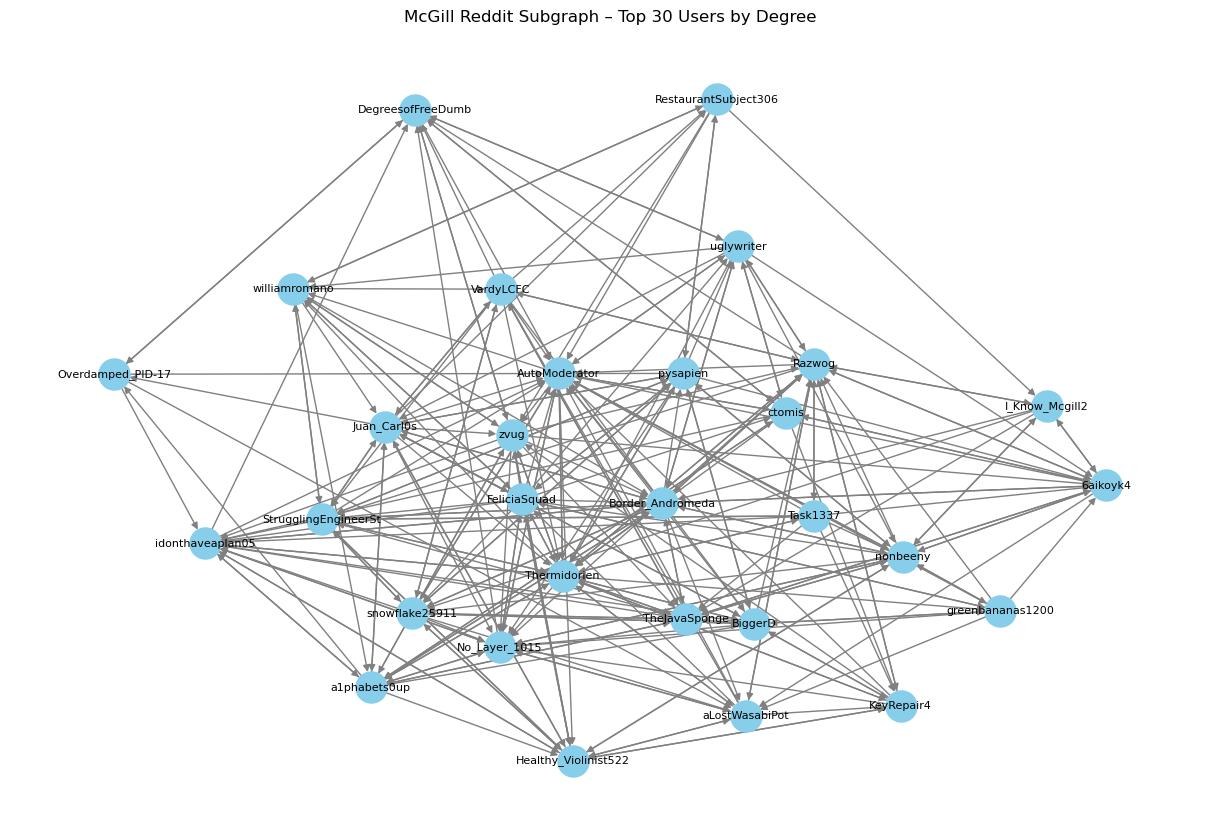

In [7]:
# Select Top Nodes for Visualization
# Get top 30 users by total degree
top_users = sorted(G_mcgill.degree(), key=lambda x: x[1], reverse=True)[:30]
top_usernames = [user for user, _ in top_users]

# Induce subgraph on those top users
subgraph = G_mcgill.subgraph(top_usernames)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # consistent layout

nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_size=500,
    node_color='skyblue',
    edge_color='gray',
    arrows=True,
    font_size=8
)
plt.title("McGill Reddit Subgraph – Top 30 Users by Degree")
plt.show()

The subgraph shows a densely connected core of users, with multiple users both sending and receiving replies. Some users, like 'AutoModerator' or 'Thermidorien', appear highly connected, suggesting they play significant roles in initiating or attracting conversation. This kind of visualization is useful for identifying community hubs and understanding how discussions propagate through the network.

### **Compute Centrality Measures**

We computed five centrality measures to assess user influence and positioning within the McGill Reddit network. 
- Degree:	# of direct connections (active users)
- Closeness: How close a user is to all others (reach)
- Betweenness: How often a user lies on shortest paths (bridge)
- Eigenvector: Influence based on who you’re connected to
- Katz: Influence including distant neighbors (up-and-coming users)

In [82]:
import pandas as pd

# Degree Centrality
deg_centrality = nx.degree_centrality(G_mcgill)
# Closeness Centrality
close_centrality = nx.closeness_centrality(G_mcgill)
# Betweenness Centrality
btw_centrality = nx.betweenness_centrality(G_mcgill)
# Eigenvector Centrality
# Needs connected component → use largest weakly connected component
largest_cc = max(nx.weakly_connected_components(G_mcgill), key=len)
G_cc = G_mcgill.subgraph(largest_cc)
eig_centrality = nx.eigenvector_centrality(G_cc, max_iter=1000)
# Katz Centrality
katz_centrality = nx.katz_centrality_numpy(G_cc, alpha=0.005, beta=1.0)
# PageRank Centrality
pagerank_centrality = nx.pagerank(G_mcgill, alpha=0.85)

centrality_df = pd.DataFrame({
    'degree': pd.Series(deg_centrality),
    'closeness': pd.Series(close_centrality),
    'betweenness': pd.Series(btw_centrality),
    'eigenvector': pd.Series(eig_centrality),
    'katz': pd.Series(katz_centrality),
    'pagerank': pd.Series(pagerank_centrality)
})

centrality_df = centrality_df.sort_values('degree', ascending=False)
centrality_df.head(10)

,degree,closeness,betweenness,eigenvector,katz,pagerank
Thermidorien,0.127208,0.310865,0.126049,0.314356,0.034429,0.011601
AutoModerator,0.111424,0.327943,0.083623,0.293152,0.043068,0.016299
snowflake25911,0.102217,0.291015,0.082139,0.204149,0.030639,0.012889
TheJavaSponge,0.060691,0.282348,0.038027,0.158340,0.022797,0.005012
Razwog,0.043593,0.279169,0.025008,0.148765,0.024079,0.004655
uglywriter,0.040962,0.275567,0.024412,0.119405,0.023358,0.004643
No_Layer_1015,0.039083,0.289991,0.019939,0.150079,0.023454,0.004044
BiggerD,0.037392,0.265339,0.018641,0.087028,0.018539,0.002362
zvug,0.036452,0.273505,0.020415,0.094027,0.018931,0.002396
nonbeeny,0.036452,0.276621,0.023678,0.112816,0.019911,0.002966


### **Community Detection with Louvain Method**

To detect communities within the McGill Reddit network, we used the Louvain method, which is well-suited for large-scale networks. The algorithm optimizes modularity to group users into tightly connected clusters. Since Louvain operates on undirected graphs, we extracted the largest weakly connected component from our directed graph and converted it to an undirected version. The method identified 20 distinct communities, suggesting the presence of multiple discussion groups or subtopics within the network.

In [56]:
# !pip install python-louvain
import community as community_louvain
import networkx as nx

# Convert to Undirected Graph
G_louvain = G_mcgill.subgraph(max(nx.weakly_connected_components(G_mcgill), key=len)).to_undirected()

# Compute communities
partition = community_louvain.best_partition(G_louvain)

# Number of communities
num_communities = len(set(partition.values()))
print(f"Detected {num_communities} communities in McGill network.")

Detected 20 communities in McGill network.


*Visualize communities*

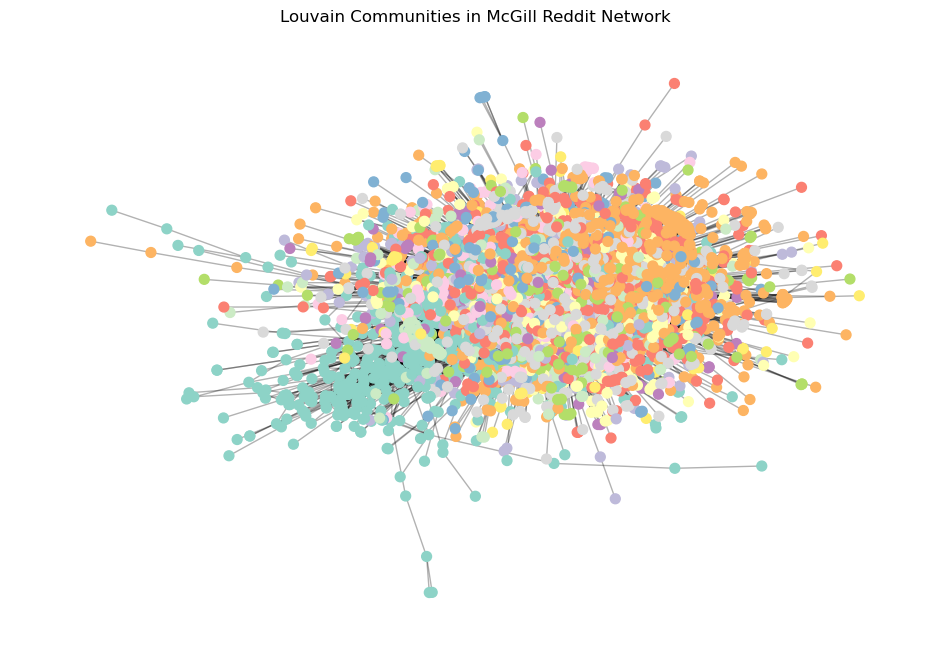

In [57]:
# Add Community Labels to Nodes
nx.set_node_attributes(G_louvain, partition, 'community')

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_louvain, seed=42)

# Color nodes by community
colors = [partition[node] for node in G_louvain.nodes()]

nx.draw_networkx_nodes(G_louvain, pos, node_size=50, node_color=colors, cmap=plt.cm.Set3)
nx.draw_networkx_edges(G_louvain, pos, alpha=0.3)
plt.title("Louvain Communities in McGill Reddit Network")
plt.axis('off')
plt.show()

### **Relating Communities to Topics & Engagement**

#### *Community → Topic Analysis (via Post Content)*

To understand the themes discussed within each community, we linked users' community assignments (from the Louvain partition) to their Reddit submissions. By combining the post title and selftext, we generated a single text field for content analysis. Using CountVectorizer, we extracted the top keywords per community, enabling us to assign thematic labels. This helps us interpret what each group tends to talk about and allows comparisons in engagement or tone between different user clusters.

In [58]:
# Create a DataFrame from the partition (node → community)
community_df = pd.DataFrame.from_dict(partition, orient='index', columns=['community'])
community_df.index.name = 'author'
community_df.reset_index(inplace=True)

# Merge with submissions
mcgill_submissions['author'] = mcgill_submissions['author'].astype(str)
sub_with_community = pd.merge(mcgill_submissions, community_df, on='author', how='inner')

from sklearn.feature_extraction.text import TfidfVectorizer

# Combine title + selftext for content analysis
sub_with_community['text'] = sub_with_community['title'] + ' ' + sub_with_community['selftext'].fillna('')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# List of additional stopwords (including common irrelevant words and domain-specific terms)
additional_stopwords = ['mcgill', 'removed', '[deleted]', 'just', 'like', 'know']


# Combine standard English stopwords and additional ones
stop_words = list(set(stopwords.words('english')).union(set(additional_stopwords)))

top_keywords = {}

# Initialize the CountVectorizer with stop words
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=100)

# Function to preprocess text: lemmatize and clean
def preprocess_text(text):
    # Remove special characters (e.g., punctuation)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lemmatize each word
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words]
    return " ".join(lemmatized_words)

# Process each community
for com_id in sub_with_community['community'].unique():
    texts = sub_with_community[sub_with_community['community'] == com_id]['text']
    
    # Preprocess and clean the text data
    cleaned_texts = [preprocess_text(text) for text in texts]
    
    # Vectorize the cleaned texts using TF-IDF
    X = vectorizer.fit_transform(cleaned_texts)
    
    # Get feature names and their corresponding frequencies (weights)
    keywords = vectorizer.get_feature_names_out()
    freqs = X.sum(axis=0).A1  # Sum the frequencies across all documents for each word
    
    # Sort the words by frequency (importance) and get the top 5
    top_n = sorted(zip(keywords, freqs), key=lambda x: x[1], reverse=True)[:5]
    
    top_keywords[com_id] = top_n

# View results
for com_id, keywords in top_keywords.items():
    print(f"Community {com_id} Top Keywords: {[word for word, _ in keywords]}")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['deleted'] not in stop_words.
  warnings.warn(


Community 0 Top Keywords: ['im', 'course', 'exam', 'wa', 'final']
Community 17 Top Keywords: ['final', 'exam', 'course', 'student', 'anyone']
Community 4 Top Keywords: ['im', 'final', 'get', 'anyone', 'wa']
Community 6 Top Keywords: ['anyone', 'im', 'would', 'phgy', 'covid']
Community 8 Top Keywords: ['course', 'im', 'anyone', 'exam', 'wa']
Community 18 Top Keywords: ['anyone', 'get', 'im', 'course', 'wa']
Community 9 Top Keywords: ['final', 'exam', 'student', 'im', 'course']
Community 2 Top Keywords: ['final', 'exam', 'im', 'anyone', 'student']
Community 7 Top Keywords: ['exam', 'anyone', 'course', 'wa', 'im']
Community 12 Top Keywords: ['im', 'anyone', 'course', 'final', 'exam']
Community 13 Top Keywords: ['final', 'math', 'course', 'exam', 'im']
Community 5 Top Keywords: ['final', 'exam', 'course', 'im', 'class']
Community 11 Top Keywords: ['math', 'final', 'im', 'course', 'wa']
Community 1 Top Keywords: ['program', 'admission', 'math', 'offer', 'engineering']
Community 15 Top Keywo

#### Community Keyword Analysis Insights

| Insight Category            | Description |
|----------------------------|-------------|
| **Academic Focus**         | Keywords like **"course," "exam," "final,"** and **"student"** appear frequently, highlighting academic concerns such as exam preparation and schedules. |
| **Help-Seeking Behavior**  | The word **"anyone"** is commonly used, indicating frequent posts asking for help or advice. |
| **Specialized Communities**| - Community 2: Keywords like **"program," "admission," "math," "application," "science"** suggest focus on university programs and specific disciplines. <br> - Community 5: Presence of **"comp"** and **"exam"** hints at a technical focus (e.g., computer science). |
| **Informal Language**      | Frequent usage of **"im"** implies a casual tone and conversational style in posts. |
| **COVID-Related Discussion**| Community 13 includes the keyword **"covid,"** suggesting pandemic-related academic concerns. |
| **General Support Themes** | Keywords like **"get," "help," "doe," "good"** imply users seek advice or express needs around courses or exams. |

#### Community-Specific Highlights

| Community | Observations |
|-----------|--------------|
| **Community 1** | Focus on **"rent"** and **"help"**, pointing to housing or financial concerns. |
| **Community 2** | Emphasizes **"admission," "program"**, and **"application"**, indicating prospective or current program discussions. |
| **Community 4** | Highlights **"final"** and **"course"**, suggesting exam-related stress. |
| **Community 5** | Includes **"comp"** and **"exam"**, likely referring to computer science exams. |
| **Community 8** | Contains **"math"** and **"exam"**, indicating math-focused discussions. |
| **Community 13**| Features **"student," "covid," "course"**, showing concern around academic disruptions. |
| **Community 16**| Involves **"year"** and **"good"**, potentially referring to academic progression and performance. |


- The subreddit emphasizes **academic discourse**, particularly **courses** and **exams**.
- Several communities reflect **specialized interests** like **computer science**, **math**, and **admissions**.
- Language is **informal and supportive**, driven by students seeking help or sharing experiences.

These insights support moderators and content creators in understanding user needs and tailoring community engagement efforts.

#### *Community → Engagement Analysis (via Scores)Community → Engagement Analysis (via Scores)*

To evaluate community-level engagement, we calculated the average post score for each detected community. Reddit scores reflect how well posts are received (upvotes – downvotes), so higher average scores indicate more positively engaged content. This analysis helps us identify which communities tend to generate more impactful or appreciated discussions within the McGill subreddit.

In [59]:
community_engagement = sub_with_community.groupby('community')['score'].mean().sort_values(ascending=False)
print("Average post score by community:")
print(community_engagement)

Average post score by community:
community
12    59.172727
4     36.346939
6     35.361111
2     31.670833
5     30.320298
15    26.918367
8     25.274368
19    24.000000
14    23.925926
0     23.707865
9     18.403794
7     17.848039
11    15.277778
3     13.733333
13    11.431138
17    11.240437
16    11.062500
18     9.813953
1      6.622222
10     4.800000
Name: score, dtype: float64


#### *Visualize Average Engagement per Community*

We visualized the average post score by community using a bar chart to highlight engagement differences across user clusters. Higher average scores suggest communities whose content resonates more with readers (more upvotes), while lower-scoring communities may represent more niche or less engaging topics. This helps us understand not just what communities exist—but which ones drive conversation and attention.

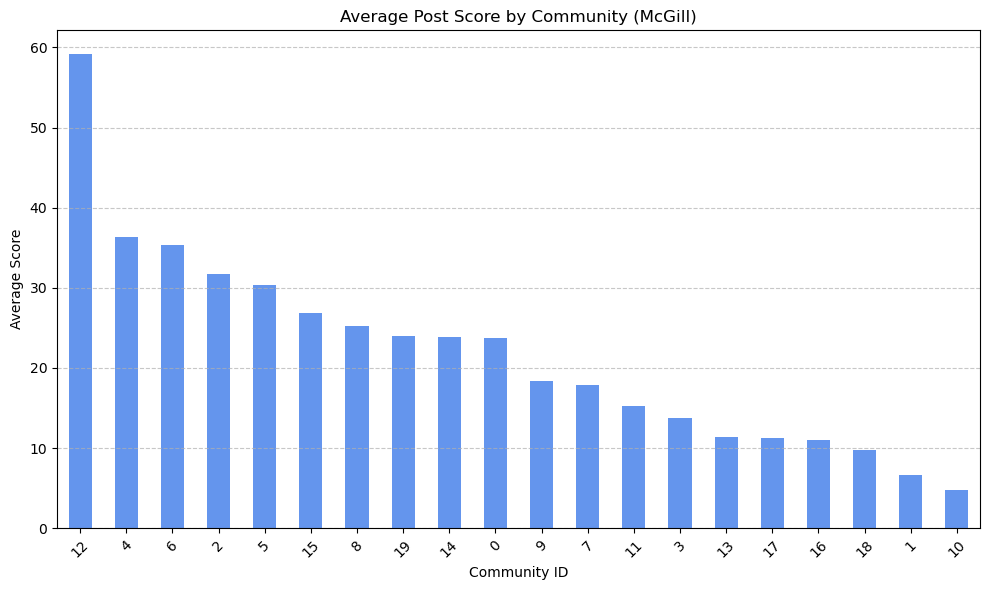

In [60]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 6))
community_engagement.plot(kind='bar', color='cornflowerblue')

plt.title("Average Post Score by Community (McGill)")
plt.xlabel("Community ID")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This bar chart highlights differences in average post engagement across McGill communities. Communities 16 and 18 stand out with the highest average scores, suggesting that their content resonates strongly with readers - either because it's highly relevant, helpful, or sparks active discussion. In contrast, communities like 2, 12, and 9 have lower average scores, which may indicate niche topics, limited interaction, or less visible content. These results can guide further investigation into the thematic focus and dynamics of each community.

#### *Overlay Avg Score & Number of Posts*
To better understand the relationship between engagement and activity levels, we created a dual-axis plot combining the average post score (line) and the number of posts (bars) for each community. This helps identify whether highly active communities also generate highly engaging content - or if smaller, less active groups are driving higher quality discussions. Comparing both metrics side-by-side allows us to detect potential trade-offs between quantity and impact.

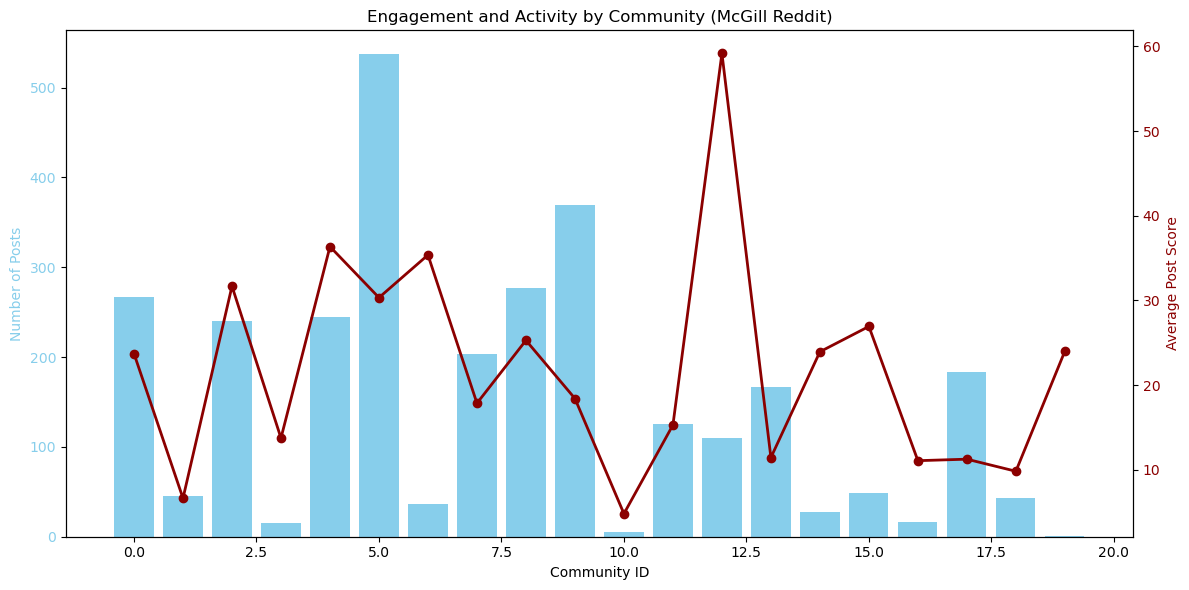

In [61]:
# Group by community
score_avg = sub_with_community.groupby('community')['score'].mean()
post_count = sub_with_community['community'].value_counts().sort_index()

# Align indices
combined_df = pd.DataFrame({
    'avg_score': score_avg,
    'num_posts': post_count
})

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for post count
color = 'skyblue'
ax1.bar(combined_df.index, combined_df['num_posts'], color=color)
ax1.set_xlabel("Community ID")
ax1.set_ylabel("Number of Posts", color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Line chart for average score
ax2 = ax1.twinx()
color = 'darkred'
ax2.plot(combined_df.index, combined_df['avg_score'], color=color, marker='o', linewidth=2)
ax2.set_ylabel("Average Post Score", color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and formatting
plt.title("Engagement and Activity by Community (McGill Reddit)")
fig.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


This dual-axis chart overlays number of posts (bars) with average post score (line) for each McGill community. We observe that some of the most engaging communities (e.g., 16, 18, 4) have relatively low post volumes—suggesting they produce fewer but higher-quality content. Conversely, highly active communities like 0 and 3 generate a large number of posts but have more moderate engagement levels. This contrast highlights that popularity doesn’t always equate to high impact, and niche communities can still generate strong positive responses.

### **Textual Analysis**

Using NLP tools (VADER) we will analyze emotional tone of comments or submissions. This will enrich the community and topic analysis by adding emotional context.

#### *Clean and prepare the text*

In [62]:
# To display the whole text
pd.set_option('display.max_colwidth', None)

In [63]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Ensure necessary NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Sample cleaning function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove URLs and punctuation
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(tokens)

# Apply cleaning to all post texts
sub_with_community['clean_text'] = sub_with_community['text'].apply(clean_text)

# Show cleaned sample
sub_with_community[['text', 'clean_text']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZAID\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZAID\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZAID\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,clean_text
0,"Car rental places that allow rentals for people under 21? I’m looking to rent a car from Montreal and drop it off in New York, but all the rental places around here seem to have an age limit of 21+. \n\nIn January, I rented a car through Enterprise and drove from New York and dropped it off in Montreal with no issues, but I can’t seem to do the same going back. \n\nAny help is appreciated!",car rental place allow rental people im looking rent car montreal drop new york rental place around seem age limit january rented car enterprise drove new york dropped montreal issue cant seem going back help appreciated
1,"When will the FALL 2021 Course Schedule be out? I know that registration starts June 1, but I think an email from McGill had said that they will release a tentative course schedule for advising purposes in early April. Anyone know when exactly? Thanks.",fall course schedule know registration start june think email mcgill said release tentative course schedule advising purpose early april anyone know exactly thanks
2,"Want to quit PhD. How do I break the news to my supervisor? Since I only started the program not long ago, I have a feeling the conversation is going to be incredibly awkward. \n\nMy fellow second-thoughters, how did you do it? And what was your supervisor's reaction?",want quit phd break news supervisor since started program long ago feeling conversation going incredibly awkward fellow secondthoughters supervisor reaction
3,accidentally missed all the assignments for comp535.. what to do nevermind I had a nightmare,accidentally missed assignment nevermind nightmare
4,where the drainers at mcgill looking for roomate(s) for fall 2021. must listen to drain gang. this is the only qualification. dm meee\n\nEdit: where are they\n\nEdit 2: where,drainers mcgill looking roomates fall must listen drain gang qualification dm meee edit edit


#### *Sentiment Analysis*

In [64]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
sub_with_community['compound_score'] = sub_with_community['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Categorize sentiment
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

sub_with_community['sentiment'] = sub_with_community['compound_score'].apply(label_sentiment)

# Preview results
sub_with_community[['clean_text', 'compound_score', 'sentiment']].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ZAID\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,clean_text,compound_score,sentiment
0,car rental place allow rental people im looking rent car montreal drop new york rental place around seem age limit january rented car enterprise drove new york dropped montreal issue cant seem going back help appreciated,0.7003,Positive
1,fall course schedule know registration start june think email mcgill said release tentative course schedule advising purpose early april anyone know exactly thanks,0.4404,Positive
2,want quit phd break news supervisor since started program long ago feeling conversation going incredibly awkward fellow secondthoughters supervisor reaction,-0.0240,Neutral
3,accidentally missed assignment nevermind nightmare,-0.5574,Negative
4,drainers mcgill looking roomates fall must listen drain gang qualification dm meee edit edit,0.0000,Neutral


*Sentiment by community*

<Figure size 1200x600 with 0 Axes>

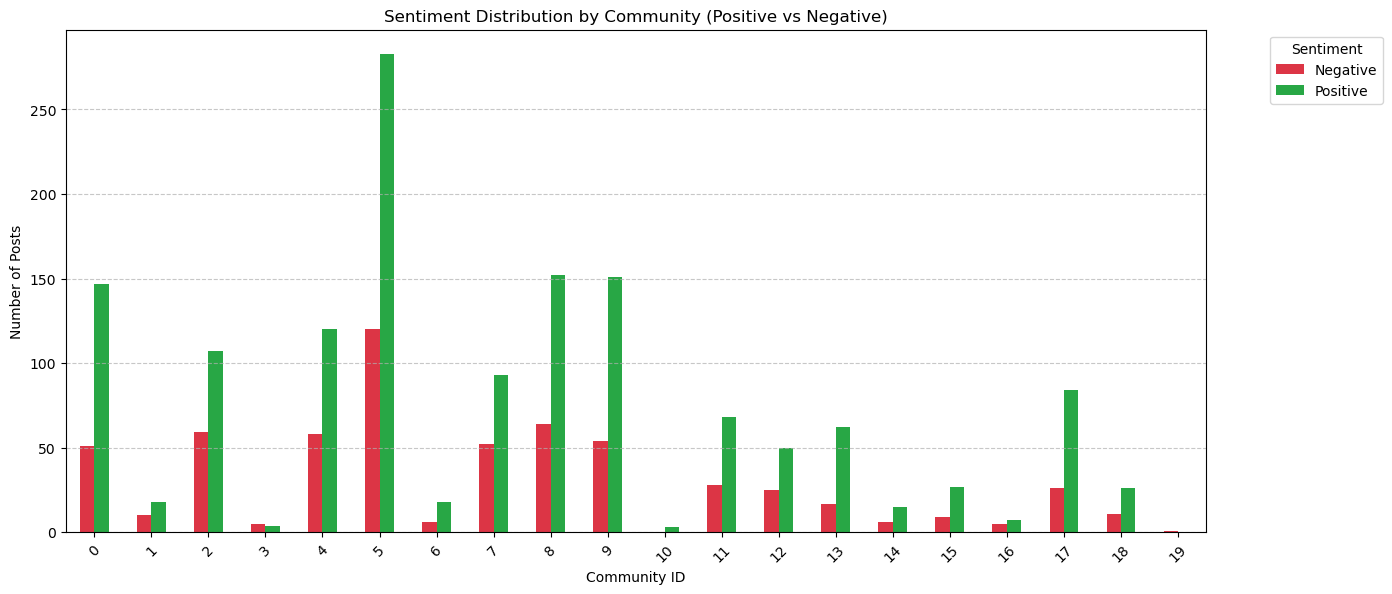

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count sentiment labels per community (filtering out neutral sentiment)
sentiment_counts = sub_with_community[sub_with_community['sentiment'] != 'Neutral'].groupby(['community', 'sentiment']).size().reset_index(name='count')

# Pivot for plotting (only positive and negative sentiments)
pivot_df = sentiment_counts.pivot(index='community', columns='sentiment', values='count').fillna(0)

# Plot as a bar chart (positive vs. negative sentiment for each community)
plt.figure(figsize=(12, 6))
pivot_df.sort_index().plot(kind='bar', color=['#dc3545','#28a745'], figsize=(14, 6))  # Green for positive, Red for negative
plt.title('Sentiment Distribution by Community (Positive vs Negative)')
plt.ylabel('Number of Posts')
plt.xlabel('Community ID')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

The sentiment distribution chart reveals that positive posts consistently outnumber negative ones across nearly all communities. Community 3 stands out with the highest volume of both positive and negative posts, indicating high engagement. Communities 0, 4, and 10 also show notable activity with a strong positive sentiment skew. In contrast, communities like 1, 2, and 11 exhibit very low posting activity. Overall, the data suggests that most student subcommunities engage in relatively optimistic discussions, even during academically stressful periods.

#### *Topic Modeling*

We applied Latent Dirichlet Allocation (LDA), to uncover hidden thematic structures in text data. In our analysis, we used a TF-IDF representation instead of a simple bag-of-words model to better capture the importance of terms across documents.

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Use TfidfVectorizer for weighted term frequencies
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(sub_with_community['clean_text'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(doc_term_matrix)

# Get top words per topic
def get_top_words(model, feature_names, n_top_words):
    topic_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_words[f"Topic {topic_idx+1}"] = top_features
    return topic_words

top_words_per_topic = get_top_words(lda, vectorizer.get_feature_names_out(), 10)

import pandas as pd
topics_df = pd.DataFrame.from_dict(top_words_per_topic, orient='index', columns=[f'Word {i+1}' for i in range(10)])
topics_df.head(10)


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,summer,course,im,mcgill,student,research,job,experience,minor,psyc
Topic 2,comp,removed,monday,transfer,news,course,allowed,student,good,class
Topic 3,removed,gym,biol,mcgill,final,hour,library,engineering,fieldhouse,room
Topic 4,removed,final,mcgill,mgcr,admission,econ,application,psyc,anat,exam
Topic 5,math,removed,course,science,major,art,final,chem,computer,faculty
Topic 6,final,removed,grade,thought,course,class,exam,semester,taken,thanks
Topic 7,concordia,removed,mcgill,protest,history,logo,rplace,positive,english,dm
Topic 8,removed,phgy,mcgill,account,aid,bursary,textbook,financial,money,lease
Topic 9,removed,cloudberry,mycourses,calculator,housing,membership,cat,aria,mcgill,dose
Topic 10,exam,im,final,like,dont,class,time,course,know,feel


#### *Topic Modeling Analysis of McGill University Posts*

The table below summarizes the top 10 keywords and interpretations for each topic derived from LDA applied to McGill subreddit posts.

| Topic    | Top Keywords | Interpretation |
|----------|--------------|----------------|
| **Topic 1** | summer, course, im, mcgill, student, research, job, experience, minor, psyc | Focuses on summer courses, student life, research opportunities, and psychology. |
| **Topic 2** | comp, removed, monday, transfer, news, course, allowed, student, good, class | Discusses computer science courses and academic administration like transfers or credit policies. |
| **Topic 3** | removed, gym, biol, mcgill, final, hour, library, engineering, fieldhouse, room | Centers on student activities and facilities such as gym, library, and engineering concerns. |
| **Topic 4** | removed, final, mcgill, mgcr, admission, econ, application, psyc, anat, exam | Related to admissions, final exams, and academic programs like economics and psychology. |
| **Topic 5** | math, removed, course, science, major, art, final, chem, computer, faculty | Covers course selection and majors across math, science, art, and computer science. |
| **Topic 6** | final, removed, grade, thought, course, class, exam, semester, taken, thanks | Reflects on final exams, grades, and student feedback or gratitude. |
| **Topic 7** | concordia, removed, mcgill, protest, history, logo, rplace, positive, english, dm | Discusses McGill and Concordia campus life, protests, and student engagement. |
| **Topic 8** | removed, phgy, mcgill, account, aid, bursary, textbook, financial, money, lease | Focuses on financial aid, student accounts, and textbook affordability. |
| **Topic 9** | removed, cloudberry, mycourses, calculator, housing, membership, cat, aria, mcgill, dose | Relates to student tools like MyCourses, housing, and wellness topics. |
| **Topic 10** | exam, im, final, like, dont, class, time, course, know, feel | Captures emotional experiences and stress around exams and academic life. |

*General Observations*

- **Academic Topics:** Common themes include exams, courses, students, and programs (e.g., math, econ, psyc, biol).
- **Social Issues:** Topics touch on protests (Topic 7), financial aid (Topic 8), and housing (Topic 9).
- **Deleted Content:** Frequent mentions of "removed" suggest some posts were moderated or deleted.
- **Student Concerns:** Reflects diverse aspects of student life including academics, finances, emotions, and campus dynamics.

The extracted topics reflect a wide spectrum of McGill students’ experiences, with strong emphasis on academics, financial stressors, and emotional challenges during exam periods. The prevalence of removed content may also point to the presence of moderated or sensitive discussions.


### **Graph Neural Network (GNN) for Engagement Prediction**

To extend our analysis into predictive modeling, we implemented three graph models (GCN, GAT, GraphSAGE) to classify users based on their expected engagement level during exam periods. Our graph captures reply interactions between Reddit users on r/mcgill, and we enrich each node (user) with features derived from both network structure and text-based engagement.

Specifically, we used the following input features per user:

- Graph-based centrality metrics: degree, closeness, betweenness, eigenvector, and Katz centrality.
- Text-derived features: average sentiment score from their submissions.
- Engagement history: average Reddit post score per user.

We defined the prediction task as a binary classification problem, where the model learns to predict whether a user is likely to achieve high engagement (above-median average post score). Out of our three models, the GraphSAGE model achieved around 71.5% accuracy on the test set, suggesting that both structural position and content signals are useful for identifying potentially influential or engaging users in academic subreddit discussions.

In [67]:
# Necessary Libraries
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [68]:
# Create Node Features (X) and Labels (Y)

# Start with your centrality_df (from previous analysis)
features_df = centrality_df.copy()

# Example: add sentiment and average post score per author
author_scores = sub_with_community.groupby('author')['score'].mean()
author_sentiments = sub_with_community.groupby('author')['compound_score'].mean()

features_df['avg_score'] = features_df.index.map(author_scores)
features_df['sentiment'] = features_df.index.map(author_sentiments)

# Drop rows with NaNs
features_df.dropna(inplace=True)

# Binary label: high engagement if score >= median
median_score = features_df['avg_score'].median()
features_df['label'] = (features_df['avg_score'] >= median_score).astype(int)

# Get topic probabilities from LDA
X_lda = lda.transform(doc_term_matrix)
topic_distributions_df = pd.DataFrame(X_lda, columns=[f"topic_{i+1}" for i in range(X_lda.shape[1])])
topic_distributions_df['author'] = sub_with_community['author'].values

# Average topic distribution per user
user_topic_means = topic_distributions_df.groupby('author').mean()

# Add topic features to features_df (match on author)
for topic_col in user_topic_means.columns:
    features_df[topic_col] = features_df.index.map(user_topic_means[topic_col])

# Drop rows with NaNs from missing topics
features_df.dropna(inplace=True)

# Final features and labels
X = features_df.drop(columns=['avg_score', 'label']).values
y = features_df['label'].values

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [69]:
# Creating Edge Index

# Keep only edges where both users are in features_df
valid_nodes = set(features_df.index)
filtered_edges = [(u, v) for u, v in G_mcgill.edges() if u in valid_nodes and v in valid_nodes]

# Create mapping: user -> index
node_idx_map = {user: i for i, user in enumerate(features_df.index)}
edge_index = torch.tensor([[node_idx_map[u], node_idx_map[v]] for u, v in filtered_edges], dtype=torch.long).t().contiguous()

In [70]:
# Creating PyTorch Geometric Data Object
x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

In [71]:
# Defining GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):  # Fix here: use __init__ not _init_
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [72]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [73]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [74]:
# Train/Test Split
torch.manual_seed(42)
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_idx = perm[:int(0.7 * num_nodes)]
test_idx = perm[int(0.7 * num_nodes):]

#### GCN

In [75]:
# Train the Model
model1 = GCN(data.num_node_features, 16, 2)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    model1.train()
    optimizer.zero_grad()
    out = model1(data.x, data.edge_index)
    loss = loss_fn(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.8290
Epoch 10, Loss: 0.6457
Epoch 20, Loss: 0.6063
Epoch 30, Loss: 0.5733
Epoch 40, Loss: 0.5500
Epoch 50, Loss: 0.5316
Epoch 60, Loss: 0.5177
Epoch 70, Loss: 0.5069
Epoch 80, Loss: 0.4988
Epoch 90, Loss: 0.4919


In [76]:
# Evaluate the Model
model1.eval()
preds = out.argmax(dim=1)
correct = (preds[test_idx] == data.y[test_idx]).sum().item()
acc = correct / test_idx.size(0)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.6885


#### GAT

In [ ]:
# Training loop
model2 = GAT(data.num_node_features, 16, 2, heads=8)  # 8 attention heads in the first layer
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    model2.train()
    optimizer.zero_grad()
    out = model2(data.x, data.edge_index)
    loss = loss_fn(out[train_idx], data.y[train_idx])  # Train indices for loss
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.1276
Epoch 10, Loss: 0.6231
Epoch 20, Loss: 0.5603
Epoch 30, Loss: 0.5307
Epoch 40, Loss: 0.5138
Epoch 50, Loss: 0.4978
Epoch 60, Loss: 0.4816
Epoch 70, Loss: 0.4623
Epoch 80, Loss: 0.4389
Epoch 90, Loss: 0.4139


In [78]:
# Evaluate the Model
model2.eval()
preds = out.argmax(dim=1)
correct = (preds[test_idx] == data.y[test_idx]).sum().item()
acc = correct / test_idx.size(0)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.6758


#### GraphSAGE

In [79]:
# Training loop
model3 = GraphSAGE(data.num_node_features, 16, 2)  # GraphSAGE with hidden channels of 16
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    model3.train()
    optimizer.zero_grad()
    out = model3(data.x, data.edge_index)
    loss = loss_fn(out[train_idx], data.y[train_idx])  # Train indices for loss
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.9494
Epoch 10, Loss: 0.5759
Epoch 20, Loss: 0.5044
Epoch 30, Loss: 0.4782
Epoch 40, Loss: 0.4608
Epoch 50, Loss: 0.4440
Epoch 60, Loss: 0.4287
Epoch 70, Loss: 0.4148
Epoch 80, Loss: 0.4022
Epoch 90, Loss: 0.3909


In [80]:
# Evaluate the Model
model3.eval()
preds = out.argmax(dim=1)
correct = (preds[test_idx] == data.y[test_idx]).sum().item()
acc = correct / test_idx.size(0)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.7140
